### 1. setting and data

In [11]:
#install module
!pip install --upgrade pip
!pip install pyyaml pandas numpy matplotlib seaborn scikit-learn
!pip uninstall keras -y
!pip install "tensorflow-macos>=2.16"
!pip install opencv-python

  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
Using cached keras-3.10.0-py3-none-any.whl (1.4 MB)


In [2]:
import sys, os

# 현재 실행 중인 노트북 기준 루트 디렉토리 잡기 (notebook과 config 폴더가 같은 상위 폴더에 있어야 함)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
#import module
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from config.load_config import load_config
from data.split_dataset import data_count, split_dataset_by_class
from data.dataloader import get_generators
from models.build_model import get_model
from models.build_model import build_model
from train.optimizer import get_optimizer
from train.callbacks import get_callbacks
from train.trainer import train_model
from utils.evaluation import evaluate_model
from utils.evaluation import plot_confusion_matrix
from utils.evaluation import plot_train_history
from utils.evaluation import show_top_misclassified
from utils.evaluation import plot_metrics_text
from utils.save_results import save_results


/Users/vnlt/PROJECT/ex-cnn-cv/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### change the config path

In [12]:
# Load configuration
config = load_config('/Users/vnlt/PROJECT/ex-cnn-cv/config/config.yaml')
data_dir = f"{config['base_output_dir']}/seed{config['seed']}"
batch_size = config['batch_size']
save_dir = f"results/{config['experiment_id']}"
os.makedirs(save_dir, exist_ok=True)


In [13]:
print(type(config))
print(config)


<class 'dict'>
{'experiment_id': 'EfficientNetB0_v1_test2', 'backbone_name': 'EfficientNetB0', 'original_dataset_dir': '/Volumes/PortableSSD/data', 'base_output_dir': '/Users/vnlt/PROJECT/ex-cnn-cv/data/dataset', 'input_shape': [224, 224, 3], 'train_ratio': 0.7, 'val_ratio': 0.2, 'test_ratio': 0.1, 'seed': 42, 'augmentations': None, 'epochs': 3, 'batch_size': 5, 'optimizer': 'adamw', 'learning_rate': 0.0001, 'weight_decay': '1e-5', 'patience': 10, 'dropout_rate': 0.5, 'save_best_only': True, 'model_save_dir': None, 'num_classes': 5}


### checkpoint-split dataset

In [ ]:
# split dataset
class_image_counts, images, min_count = data_count(
    original_dataset_dir=config['original_dataset_dir']
)

split_dataset_by_class(
    original_dataset_dir=config['original_dataset_dir'],
    min_count=min_count,
    images=images,
    base_output_dir=f"{config['base_output_dir']}/seed{config['seed']}",
    train_ratio=config['train_ratio'],
    val_ratio=config['val_ratio'],
    test_ratio=config['test_ratio'],
    seed=config['seed']
)

In [14]:
# data generators - preprocessing and augmentation
train_gen, val_gen, test_gen = get_generators(
    model_name=config['backbone_name'],
    input_shape=tuple(config['input_shape']),
    batch_size=config['batch_size'],
    data_dir=data_dir,
    augmentations=config['augmentations']
)

Found 50 images belonging to 5 classes.
Found 5 images belonging to 5 classes.
Found 15 images belonging to 5 classes.


In [15]:
from tensorflow.keras.optimizers import Adam, AdamW
print(Adam)
print(AdamW)


<class 'keras.src.optimizers.adam.Adam'>
<class 'keras.src.optimizers.adamw.AdamW'>


### 2. model training

In [8]:
# model structure
model = build_model(
    backbone_name=config['backbone_name'],
    input_shape=tuple(config['input_shape']),
    num_classes=config['num_classes'],
    dropout_rate=config['dropout_rate']
)
# compile model
optimizer = get_optimizer(
    optimizer_name=config['optimizer'],
    learning_rate=config['learning_rate'],
    weight_decay=config.get('weight_decay', 0.0)
)

callbacks = get_callbacks(
    model_name=config['backbone_name'],
    save_dir=f"results/{config['experiment_id']}",
    patience=config['patience']
)

In [9]:
# model training
history = train_model(
    model,
    train_gen,
    val_gen,
    epochs=config['epochs'],
    callbacks=callbacks,
    optimizer=optimizer
)

/Users/vnlt/PROJECT/ex-cnn-cv/.venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/Users/vnlt/PROJECT/ex-cnn-cv/.venv/lib/python3.9/site-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.1546 - loss: 1.6269

10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 581ms/step - accuracy: 0.1587 - loss: 1.6270 - val_accuracy: 0.6000 - val_loss: 1.3155 - learning_rate: 1.0000e-04
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.3045 - loss: 1.4863

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 432ms/step - accuracy: 0.3169 - loss: 1.4816 - val_accuracy: 0.8000 - val_loss: 1.2417 - learning_rate: 1.0000e-04
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.5202 - loss: 1.3305

10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 428ms/step - accuracy: 0.5311 - loss: 1.3206 - val_accuracy: 1.0000 - val_loss: 1.1336 - learning_rate: 1.0000e-04


### 3. evaluation and results

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [11]:
y_true, y_pred, y_prob = evaluate_model(model, test_gen)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


In [12]:
from collections import Counter
print(Counter(test_gen.classes))


Counter({0: 3, 1: 3, 2: 3, 3: 3, 4: 3})


In [13]:
# 원래 class_indices 출력
print("Original class_indices (class name → index):")
print(test_gen.class_indices)

Original class_indices (class name → index):
{'Bacterial-spot': 0, 'Healthy': 1, 'PMMoV': 2, 'Powdery-mildew': 3, 'TSWV': 4}


In [14]:
class_names = list(test_gen.class_indices.keys())

In [15]:
print("클래스 인덱스 딕셔너리:", class_names)
print("y_true에서 고유값들:", np.unique(y_true))
print("y_pred에서 고유값들:", np.unique(y_pred))


클래스 인덱스 딕셔너리: ['Bacterial-spot', 'Healthy', 'PMMoV', 'Powdery-mildew', 'TSWV']
y_true에서 고유값들: [0 1 2 3 4]
y_pred에서 고유값들: [0 3 4]


In [16]:
print("y_true shape:", y_true.shape)
print("y_true sample:", y_true[:5])


y_true shape: (15,)
y_true sample: [0 0 0 1 1]


/Users/vnlt/PROJECT/ex-cnn-cv/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vnlt/PROJECT/ex-cnn-cv/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vnlt/PROJECT/ex-cnn-cv/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

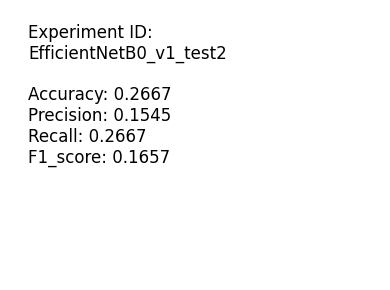

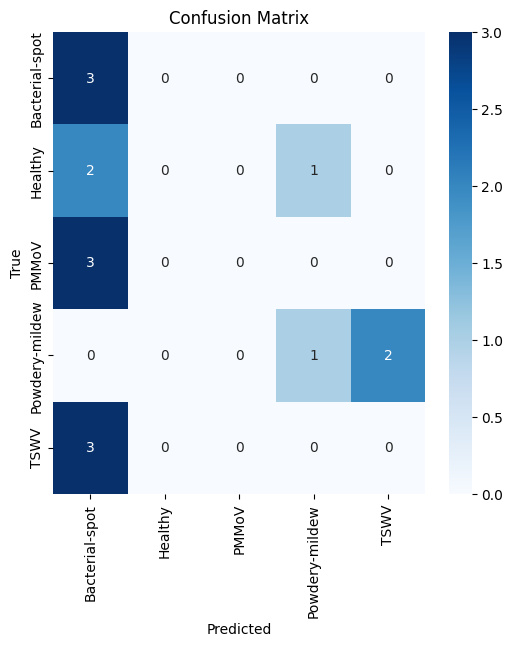

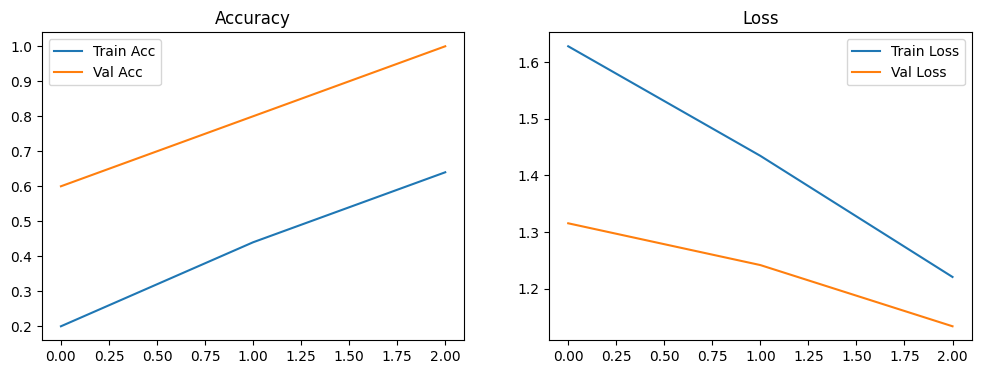

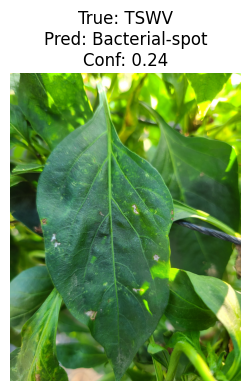

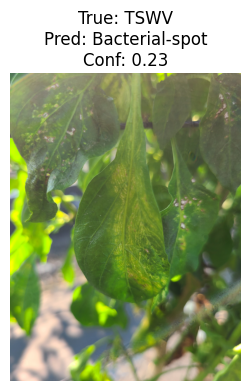

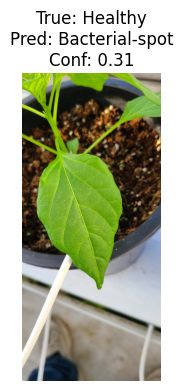

In [17]:
# results visualization
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)

metrics_dict = {
    "accuracy": report["accuracy"],
    "precision": report["macro avg"]["precision"],
    "recall": report["macro avg"]["recall"],
    "f1_score": report["macro avg"]["f1-score"]
}

plot_metrics_text(
    metrics_dict=metrics_dict,
    experiment_id=config['experiment_id'],
    save_path=f"{save_dir}/metrics_text.png"
)

plot_confusion_matrix(
    cm, 
    class_names, 
    title="Confusion Matrix", 
    save_path=f"{save_dir}/confusion_matrix.png"
)
plot_train_history(
    history,
    save_path=f"{save_dir}/history_graph.png"
)

show_top_misclassified(
    y_true,
    y_pred,
    y_prob,
    class_names,
    generator=test_gen,
    model_name=config['experiment_id'],
    save_dir=save_dir,
    top_n=3
)

### 4. results save

In [18]:

save_results(
    model_name=config['backbone_name'],
    history=history,
    cm=confusion_matrix(y_true, y_pred),
    class_names=list(test_gen.class_indices.keys()),
    report=classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys()), output_dict=True),
    save_dir= save_dir
)

print(f"\u2705 저장 완료: {save_dir}")


✅ 저장 완료: results/EfficientNetB0_v1_test2


/Users/vnlt/PROJECT/ex-cnn-cv/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vnlt/PROJECT/ex-cnn-cv/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vnlt/PROJECT/ex-cnn-cv/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz